In [114]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.functional.classification import accuracy, auroc, f1_score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### Training data

In [3]:
df_train = pd.read_json('annotations/data/subtask1/train.json')
df_train.head()

,id,text,labels,link
0,65635,THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ...,[Black-and-white Fallacy/Dictatorship],https://www.facebook.com/photo/?fbid=402355213...
1,67927,GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND AN...,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...
2,68031,PAING PHYO MIN IS FREE!,[],https://www.facebook.com/amnesty/photos/427419...
3,77490,Move your ships away!\n\noooook\n\nMove your s...,[],https://www.facebook.com/rightpatriots/photos/...
4,67641,"WHEN YOU'RE THE FBI, THEY LET YOU DO IT.",[Thought-terminating cliché],https://www.facebook.com/AddictingInfoOrg/phot...


In [4]:
df_train.shape

(7000, 4)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7000 non-null   int64 
 1   text    7000 non-null   object
 2   labels  7000 non-null   object
 3   link    7000 non-null   object
dtypes: int64(1), object(3)
memory usage: 218.9+ KB


In [6]:
labels_train = df_train['labels']
labels_train

0                  [Black-and-white Fallacy/Dictatorship]
1       [Loaded Language, Glittering generalities (Vir...
2                                                      []
3                                                      []
4                            [Thought-terminating cliché]
                              ...                        
6995    [Loaded Language, Causal Oversimplification, T...
6996                      [Loaded Language, Whataboutism]
6997                                                   []
6998                                                   []
6999                                            [Slogans]
Name: labels, Length: 7000, dtype: object

In [7]:
CLASS_NAMES = set()

for category in labels_train:
    category = list(category)
    for label in category:
        CLASS_NAMES.add(label)

CLASS_NAMES

{'Appeal to authority',
 'Appeal to fear/prejudice',
 'Bandwagon',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Whataboutism'}

In [8]:
len(CLASS_NAMES)

20

In [9]:
for label in CLASS_NAMES:
    df_train.insert(df_train.shape[1],label,[0] * df_train.shape[0],True)
df_train.shape

(7000, 24)

In [10]:
df_train.head()

,id,text,labels,link,Presenting Irrelevant Data (Red Herring),Exaggeration/Minimisation,Appeal to fear/prejudice,Reductio ad hitlerum,Causal Oversimplification,Name calling/Labeling,...,Misrepresentation of Someone's Position (Straw Man),"Obfuscation, Intentional vagueness, Confusion",Appeal to authority,Black-and-white Fallacy/Dictatorship,Flag-waving,Slogans,Doubt,Thought-terminating cliché,Repetition,Bandwagon
0,65635,THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ...,[Black-and-white Fallacy/Dictatorship],https://www.facebook.com/photo/?fbid=402355213...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,67927,GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND AN...,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,68031,PAING PHYO MIN IS FREE!,[],https://www.facebook.com/amnesty/photos/427419...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77490,Move your ships away!\n\noooook\n\nMove your s...,[],https://www.facebook.com/rightpatriots/photos/...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67641,"WHEN YOU'RE THE FBI, THEY LET YOU DO IT.",[Thought-terminating cliché],https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_train.columns

Index(['id', 'text', 'labels', 'link',
       'Presenting Irrelevant Data (Red Herring)', 'Exaggeration/Minimisation',
       'Appeal to fear/prejudice', 'Reductio ad hitlerum',
       'Causal Oversimplification', 'Name calling/Labeling', 'Smears',
       'Glittering generalities (Virtue)', 'Whataboutism', 'Loaded Language',
       'Misrepresentation of Someone's Position (Straw Man)',
       'Obfuscation, Intentional vagueness, Confusion', 'Appeal to authority',
       'Black-and-white Fallacy/Dictatorship', 'Flag-waving', 'Slogans',
       'Doubt', 'Thought-terminating cliché', 'Repetition', 'Bandwagon'],
      dtype='object')

In [12]:
for i in df_train.index:
    labels = list(df_train['labels'][i])
    for label in labels:
        df_train.at[i,label] = 1
df_train.head()

,id,text,labels,link,Presenting Irrelevant Data (Red Herring),Exaggeration/Minimisation,Appeal to fear/prejudice,Reductio ad hitlerum,Causal Oversimplification,Name calling/Labeling,...,Misrepresentation of Someone's Position (Straw Man),"Obfuscation, Intentional vagueness, Confusion",Appeal to authority,Black-and-white Fallacy/Dictatorship,Flag-waving,Slogans,Doubt,Thought-terminating cliché,Repetition,Bandwagon
0,65635,THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ...,[Black-and-white Fallacy/Dictatorship],https://www.facebook.com/photo/?fbid=402355213...,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,67927,GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND AN...,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,68031,PAING PHYO MIN IS FREE!,[],https://www.facebook.com/amnesty/photos/427419...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77490,Move your ships away!\n\noooook\n\nMove your s...,[],https://www.facebook.com/rightpatriots/photos/...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67641,"WHEN YOU'RE THE FBI, THEY LET YOU DO IT.",[Thought-terminating cliché],https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
df_train['Doubt'].value_counts()

Doubt
0    6650
1     350
Name: count, dtype: int64

In [14]:
df_train.columns

Index(['id', 'text', 'labels', 'link',
       'Presenting Irrelevant Data (Red Herring)', 'Exaggeration/Minimisation',
       'Appeal to fear/prejudice', 'Reductio ad hitlerum',
       'Causal Oversimplification', 'Name calling/Labeling', 'Smears',
       'Glittering generalities (Virtue)', 'Whataboutism', 'Loaded Language',
       'Misrepresentation of Someone's Position (Straw Man)',
       'Obfuscation, Intentional vagueness, Confusion', 'Appeal to authority',
       'Black-and-white Fallacy/Dictatorship', 'Flag-waving', 'Slogans',
       'Doubt', 'Thought-terminating cliché', 'Repetition', 'Bandwagon'],
      dtype='object')

In [15]:
column_names = df_train.columns[4:]
dictionary = {}

for label in column_names:
    dictionary[label] = [df_train[label].value_counts()[0], df_train[label].value_counts()[1]]

count_df = pd.DataFrame(dictionary)
count_df.head()

,Presenting Irrelevant Data (Red Herring),Exaggeration/Minimisation,Appeal to fear/prejudice,Reductio ad hitlerum,Causal Oversimplification,Name calling/Labeling,Smears,Glittering generalities (Virtue),Whataboutism,Loaded Language,Misrepresentation of Someone's Position (Straw Man),"Obfuscation, Intentional vagueness, Confusion",Appeal to authority,Black-and-white Fallacy/Dictatorship,Flag-waving,Slogans,Doubt,Thought-terminating cliché,Repetition,Bandwagon
0,6941,6644,6663,6937,6760,5482,5010,6512,6742,5250,6938,6979,6150,6220,6429,6333,6650,6472,6695,6903
1,59,356,337,63,240,1518,1990,488,258,1750,62,21,850,780,571,667,350,528,305,97


In [16]:
count_df.shape

(2, 20)

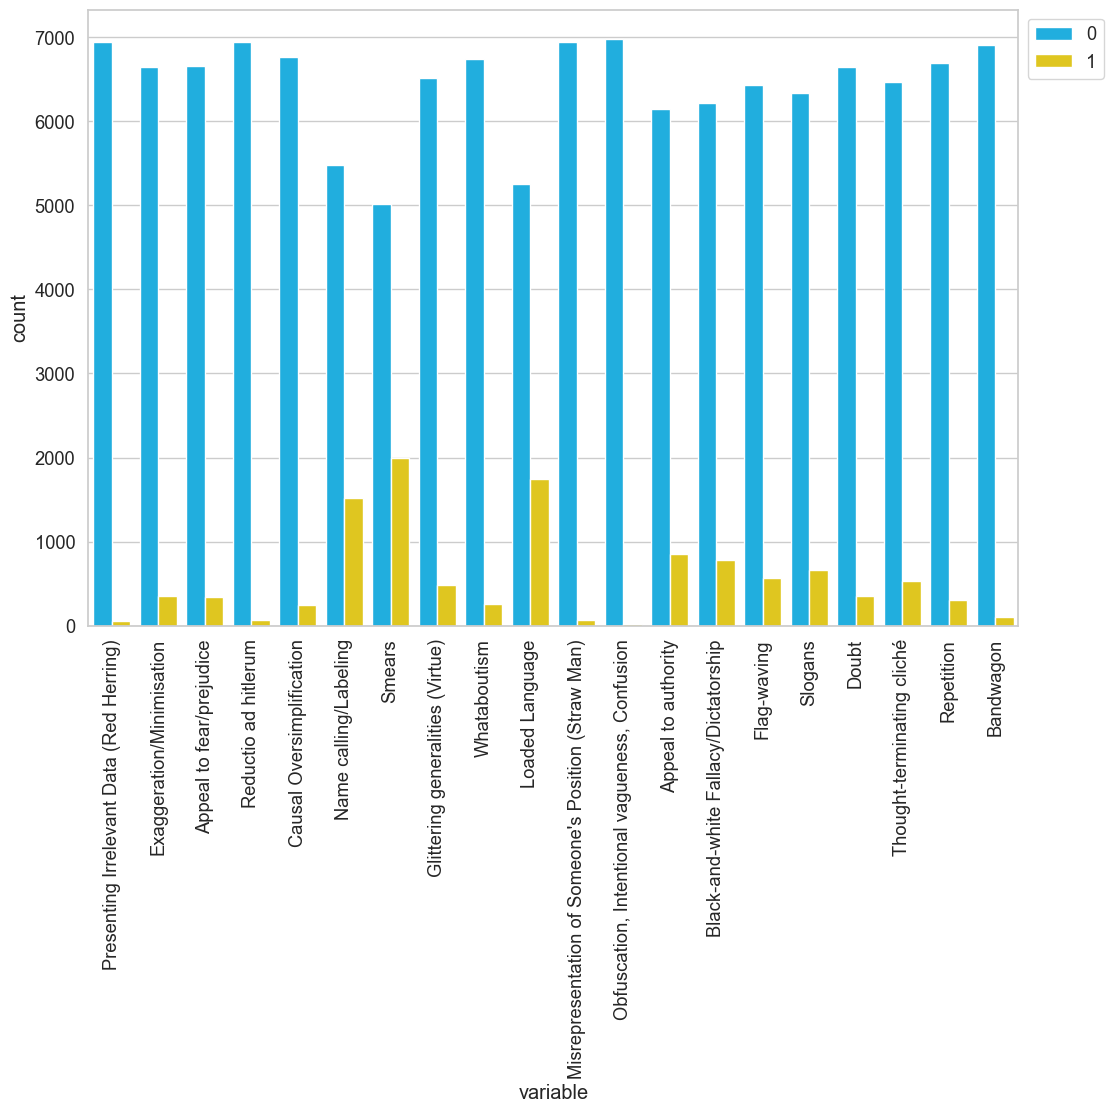

In [17]:
sns.countplot(data=df_train[column_names].melt(),x='variable',hue='value')
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=90);

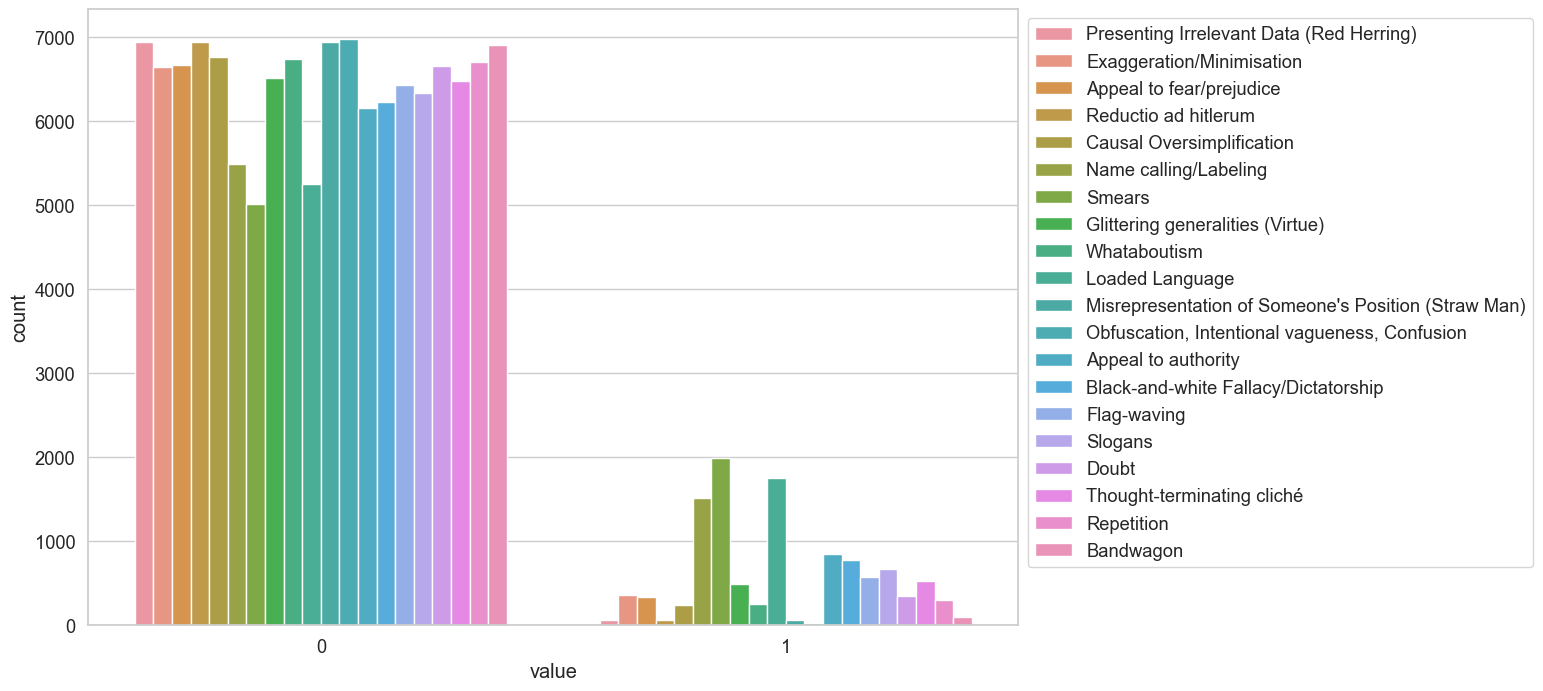

In [18]:
sns.countplot(data=df_train[column_names].melt(),x='value',hue='variable')
plt.legend(bbox_to_anchor=(1,1))

<Axes: >

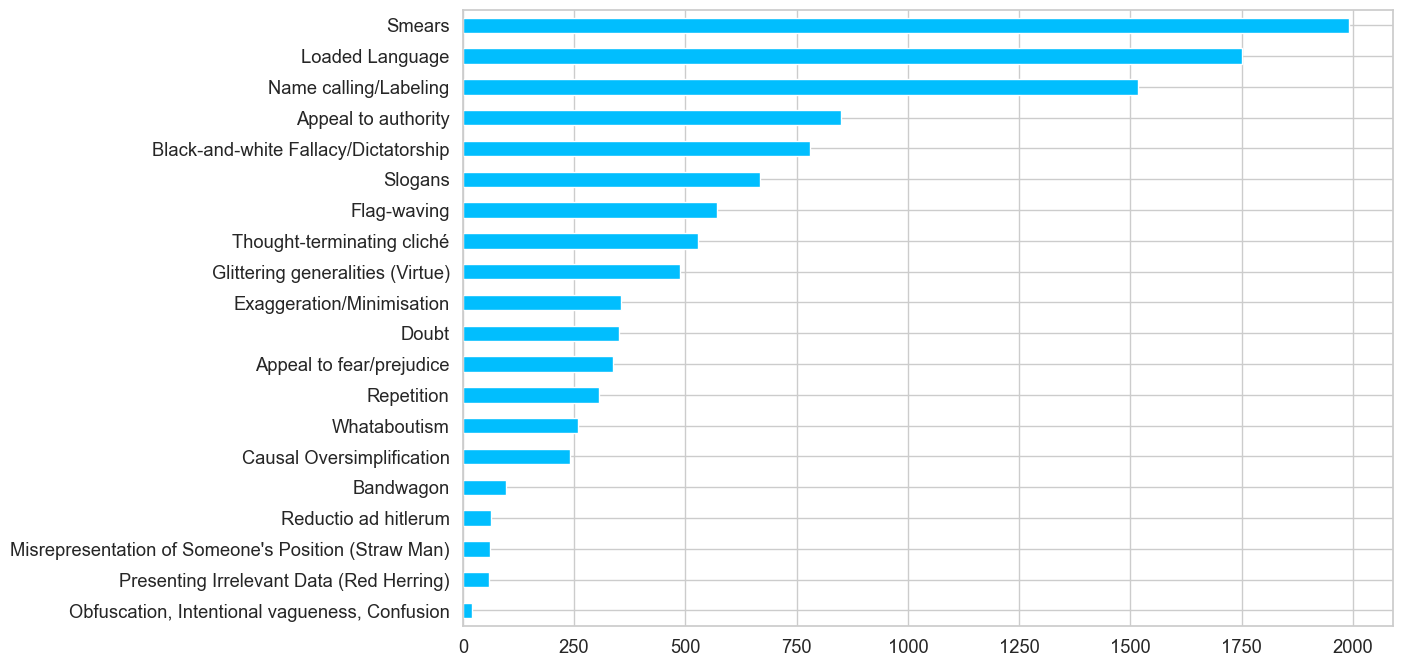

In [19]:
df_train[column_names].sum().sort_values().plot(kind='barh')

### Validation data

In [20]:
df_val = pd.read_json('annotations/data/subtask1/validation.json')
df_val.head()

,id,text,labels,link
0,63135,Critical Thinking Essentials\n\Are my biases a...,"[Doubt, Slogans]",https://www.facebook.com/SkepticalMemeSociety/...
1,78590,Trying to think of a single accomplishment...,"[Exaggeration/Minimisation, Smears]",https://www.facebook.com/unitedstatesherald/ph...
2,65834,Corporate needs you to find the difference bet...,[Thought-terminating cliché],https://www.facebook.com/photo/?fbid=356249413...
3,67394,KYLE RITTENHOUSE\nALL CHARGES\nNOT GUILTY,[Glittering generalities (Virtue)],https://www.facebook.com/TheControversia/photo...
4,67709,Al Franken explains why America should tax the...,"[Appeal to authority, Slogans, Thought-termina...",https://www.facebook.com/AddictingInfoOrg/phot...


In [21]:
df_val.shape

(500, 4)

In [22]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      500 non-null    int64 
 1   text    500 non-null    object
 2   labels  500 non-null    object
 3   link    500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [23]:
labels_val = df_val['labels']
labels_val

0                                       [Doubt, Slogans]
1                    [Exaggeration/Minimisation, Smears]
2                           [Thought-terminating cliché]
3                     [Glittering generalities (Virtue)]
4      [Appeal to authority, Slogans, Thought-termina...
                             ...                        
495         [Slogans, Name calling/Labeling, Repetition]
496                                                   []
497                                                   []
498         [Causal Oversimplification, Loaded Language]
499    [Name calling/Labeling, Appeal to authority, B...
Name: labels, Length: 500, dtype: object

In [24]:
for label in CLASS_NAMES:
    df_val.insert(df_val.shape[1],label,[0] * df_val.shape[0],True)
df_val.shape

(500, 24)

In [25]:
df_val.head()

,id,text,labels,link,Presenting Irrelevant Data (Red Herring),Exaggeration/Minimisation,Appeal to fear/prejudice,Reductio ad hitlerum,Causal Oversimplification,Name calling/Labeling,...,Misrepresentation of Someone's Position (Straw Man),"Obfuscation, Intentional vagueness, Confusion",Appeal to authority,Black-and-white Fallacy/Dictatorship,Flag-waving,Slogans,Doubt,Thought-terminating cliché,Repetition,Bandwagon
0,63135,Critical Thinking Essentials\n\Are my biases a...,"[Doubt, Slogans]",https://www.facebook.com/SkepticalMemeSociety/...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,78590,Trying to think of a single accomplishment...,"[Exaggeration/Minimisation, Smears]",https://www.facebook.com/unitedstatesherald/ph...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,65834,Corporate needs you to find the difference bet...,[Thought-terminating cliché],https://www.facebook.com/photo/?fbid=356249413...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,67394,KYLE RITTENHOUSE\nALL CHARGES\nNOT GUILTY,[Glittering generalities (Virtue)],https://www.facebook.com/TheControversia/photo...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67709,Al Franken explains why America should tax the...,"[Appeal to authority, Slogans, Thought-termina...",https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df_val.columns

Index(['id', 'text', 'labels', 'link',
       'Presenting Irrelevant Data (Red Herring)', 'Exaggeration/Minimisation',
       'Appeal to fear/prejudice', 'Reductio ad hitlerum',
       'Causal Oversimplification', 'Name calling/Labeling', 'Smears',
       'Glittering generalities (Virtue)', 'Whataboutism', 'Loaded Language',
       'Misrepresentation of Someone's Position (Straw Man)',
       'Obfuscation, Intentional vagueness, Confusion', 'Appeal to authority',
       'Black-and-white Fallacy/Dictatorship', 'Flag-waving', 'Slogans',
       'Doubt', 'Thought-terminating cliché', 'Repetition', 'Bandwagon'],
      dtype='object')

In [27]:
for i in df_val.index:
    labels = list(df_val['labels'][i])
    for label in labels:
        df_val.at[i,label] = 1
df_val.head()

,id,text,labels,link,Presenting Irrelevant Data (Red Herring),Exaggeration/Minimisation,Appeal to fear/prejudice,Reductio ad hitlerum,Causal Oversimplification,Name calling/Labeling,...,Misrepresentation of Someone's Position (Straw Man),"Obfuscation, Intentional vagueness, Confusion",Appeal to authority,Black-and-white Fallacy/Dictatorship,Flag-waving,Slogans,Doubt,Thought-terminating cliché,Repetition,Bandwagon
0,63135,Critical Thinking Essentials\n\Are my biases a...,"[Doubt, Slogans]",https://www.facebook.com/SkepticalMemeSociety/...,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,78590,Trying to think of a single accomplishment...,"[Exaggeration/Minimisation, Smears]",https://www.facebook.com/unitedstatesherald/ph...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,65834,Corporate needs you to find the difference bet...,[Thought-terminating cliché],https://www.facebook.com/photo/?fbid=356249413...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,67394,KYLE RITTENHOUSE\nALL CHARGES\nNOT GUILTY,[Glittering generalities (Virtue)],https://www.facebook.com/TheControversia/photo...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67709,Al Franken explains why America should tax the...,"[Appeal to authority, Slogans, Thought-termina...",https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0


<Axes: >

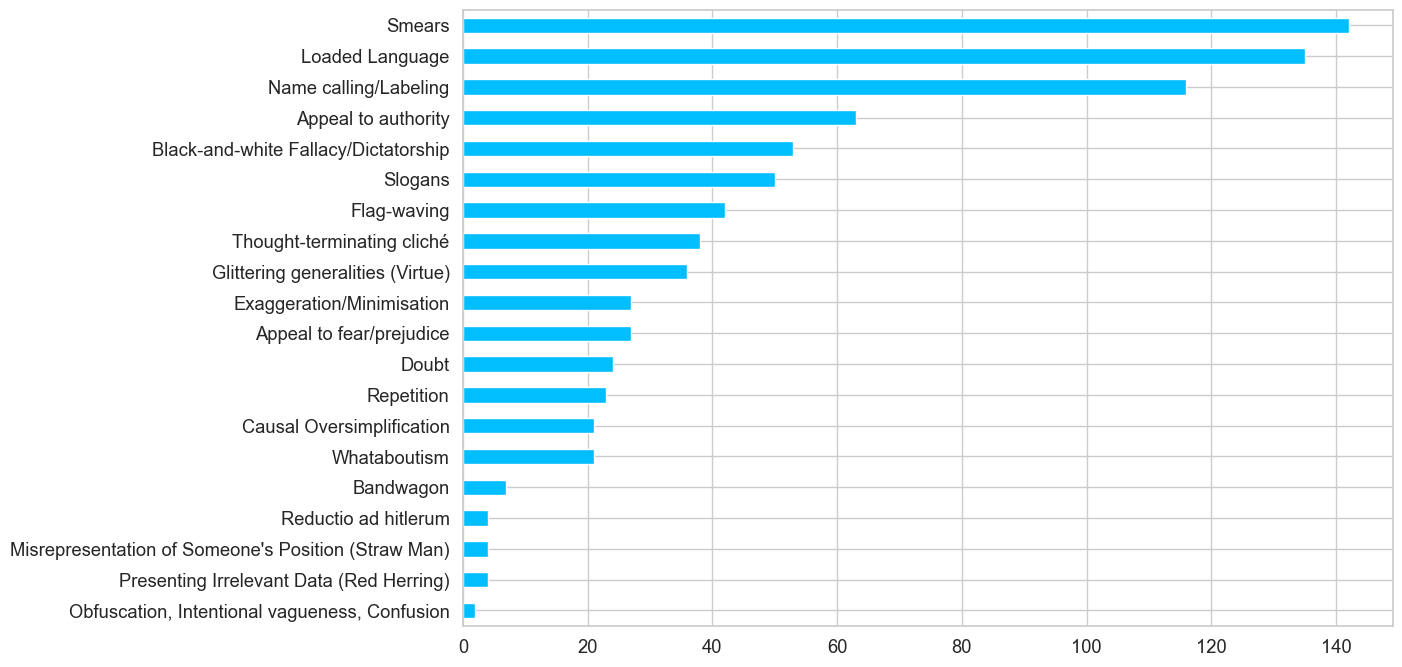

In [28]:
df_val[column_names].sum().sort_values().plot(kind='barh')

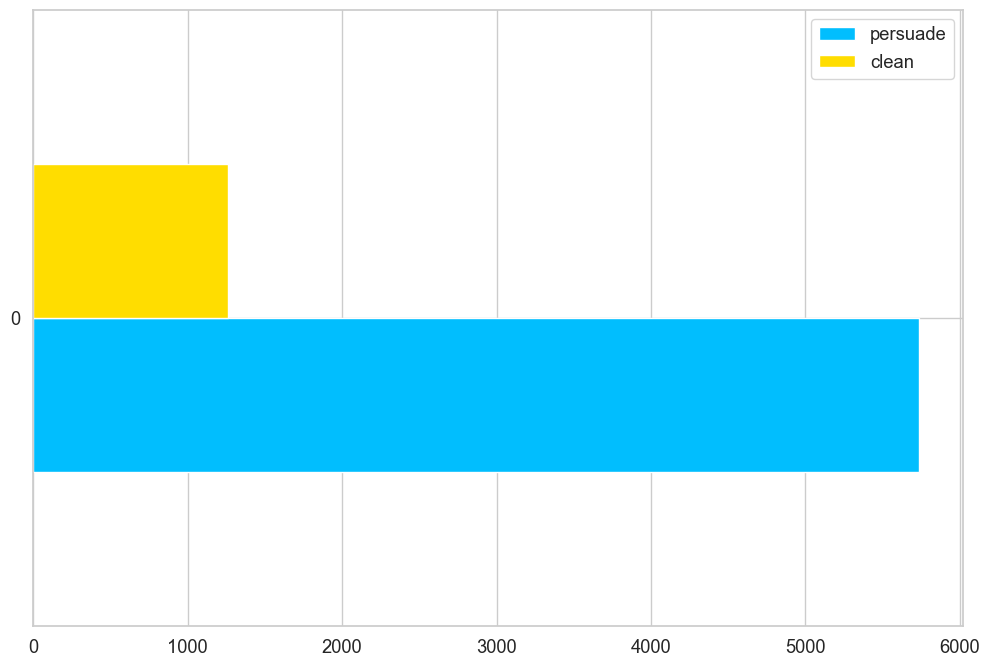

In [29]:
train_persuade = df_train[df_train[column_names].sum(axis=1) > 0]
train_clean = df_train[df_train[column_names].sum(axis=1) == 0]
pd.DataFrame(dict(
  persuade=[len(train_persuade)],
  clean=[len(train_clean)]
)).plot(kind='barh');

In [30]:
train_persuade.shape, train_clean.shape

((5736, 24), (1264, 24))

In [31]:
df_train = pd.concat([
  train_persuade.sample(2000),
  train_clean
])

df_train.shape

(3264, 24)

### Sample testing

In [32]:
df_train = df_train.drop(columns=['id','labels','link'],axis=1)
df_val = df_val.drop(columns=['id','labels','link'])

df_train.shape, df_val.shape

((3264, 21), (500, 21))

In [33]:
CLASS_NAMES

{'Appeal to authority',
 'Appeal to fear/prejudice',
 'Bandwagon',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Whataboutism'}

In [34]:
LABEL_COLUMNS = list(CLASS_NAMES)
sample_row = df_train.iloc[16]
sample_text = sample_row.text
sample_label = sample_row[LABEL_COLUMNS]

print(sample_text,end='\n\n')
print(sample_label.to_dict())

\I'm looking forward to eating some Kangaroo anus!\

{'Presenting Irrelevant Data (Red Herring)': 0, 'Exaggeration/Minimisation': 0, 'Appeal to fear/prejudice': 0, 'Reductio ad hitlerum': 0, 'Causal Oversimplification': 0, 'Name calling/Labeling': 0, 'Smears': 0, 'Glittering generalities (Virtue)': 0, 'Whataboutism': 0, 'Loaded Language': 1, "Misrepresentation of Someone's Position (Straw Man)": 0, 'Obfuscation, Intentional vagueness, Confusion': 0, 'Appeal to authority': 0, 'Black-and-white Fallacy/Dictatorship': 0, 'Flag-waving': 0, 'Slogans': 0, 'Doubt': 0, 'Thought-terminating cliché': 0, 'Repetition': 0, 'Bandwagon': 0}


In [35]:
LABEL_COLUMNS, len(LABEL_COLUMNS)

(['Presenting Irrelevant Data (Red Herring)',
  'Exaggeration/Minimisation',
  'Appeal to fear/prejudice',
  'Reductio ad hitlerum',
  'Causal Oversimplification',
  'Name calling/Labeling',
  'Smears',
  'Glittering generalities (Virtue)',
  'Whataboutism',
  'Loaded Language',
  "Misrepresentation of Someone's Position (Straw Man)",
  'Obfuscation, Intentional vagueness, Confusion',
  'Appeal to authority',
  'Black-and-white Fallacy/Dictatorship',
  'Flag-waving',
  'Slogans',
  'Doubt',
  'Thought-terminating cliché',
  'Repetition',
  'Bandwagon'],
 20)

In [36]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [37]:
encoding = tokenizer.encode_plus(sample_text,
                      add_special_tokens=True,
                      max_length=512,
                      return_token_type_ids=False,
                      padding='max_length',
                      return_attention_mask=True,
                      return_tensors='pt')
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [38]:
encoding['input_ids'].shape, encoding['attention_mask'].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [39]:
encoding['input_ids'].squeeze()[:40]

tensor([  101,   165,   146,   112,   182,  1702,  1977,  1106,  5497,  1199,
        17614, 25956,  1126,  1361,   106,   165,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [40]:
encoding['attention_mask'].squeeze()[:40]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
encoding['input_ids'].squeeze().shape

torch.Size([512])

In [42]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'].squeeze())[:20])

['[CLS]', '\\', 'I', "'", 'm', 'looking', 'forward', 'to', 'eating', 'some', 'Kang', '##aroo', 'an', '##us', '!', '\\', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


(0.0, 512.0)

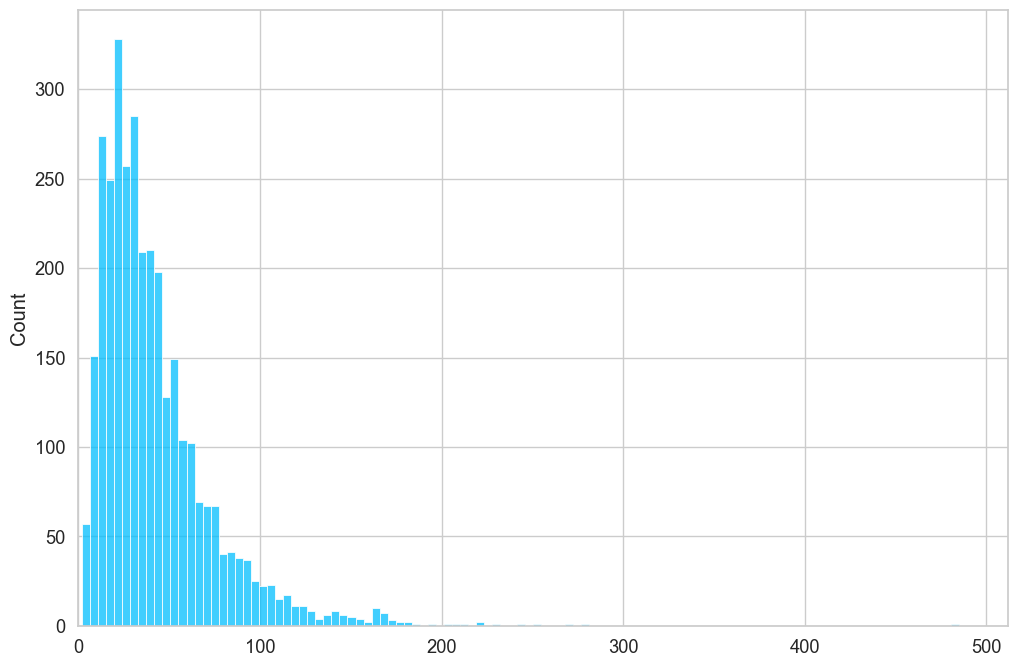

In [43]:
token_counts = []

for _, row in df_train.iterrows():
    token_count = len(tokenizer.encode(
        row['text'],
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)
plt.xlim([0,512])

In [44]:
MAX_TOKEN_COUNT = 256

### Special Tokens

In [45]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [46]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [47]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [48]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

### Creating the Dataset & Loading the model

In [49]:
class PersuasionDataset(Dataset):
    def __init__(self,
                 data: pd.DataFrame,
                 tokenizer: BertTokenizer,
                 max_token_len: int = 128):
        self.data=data
        self.tokenizer=tokenizer
        self.max_token_len=max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        meme_text = data_row.text
        labels = data_row[LABEL_COLUMNS]

        encoding = self.tokenizer.encode_plus(
            meme_text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return dict(
            meme_text=meme_text,
            input_ids=encoding['input_ids'].flatten(),
            attention_mask=encoding['attention_mask'].flatten(),
            labels=torch.FloatTensor(labels)
        )

In [50]:
train_dataset = PersuasionDataset(df_train,tokenizer,MAX_TOKEN_COUNT)
train_dataset

In [51]:
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['meme_text', 'input_ids', 'attention_mask', 'labels'])

In [52]:
sample_item['meme_text']

"CIA's OPERATION MOCKINGBIRD\\n\\n\\We'll know our disinformation program is complete when everything the American public believes is false.\\"

In [53]:
sample_item['labels'], sample_item['labels'].shape

(tensor([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 torch.Size([20]))

In [54]:
sample_item['input_ids'].shape

torch.Size([256])

In [55]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME,return_dict=True)
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [56]:
sample_item['input_ids'].unsqueeze(dim=0).shape

torch.Size([1, 256])

In [57]:
prediction = bert_model(sample_item['input_ids'].unsqueeze(dim=0),
                        sample_item['attention_mask'].unsqueeze(dim=0))

prediction.last_hidden_state.shape, prediction.pooler_output.shape

(torch.Size([1, 256, 768]), torch.Size([1, 768]))

In [58]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8)))

sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 256]), torch.Size([8, 256]))

In [59]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 256, 768]), torch.Size([8, 768]))

### Creating the Data Module

In [60]:
class PersuasionDataModule(pl.LightningDataModule):
    def __init__(self,train_df,test_df,tokenizer,batch_size=8,max_token_len=128):
        super().__init__()
        self.train_df=train_df
        self.test_df=test_df
        self.tokenizer=tokenizer
        self.batch_size=batch_size
        self.max_token_len=max_token_len

    def setup(self,stage=None):
        self.train_dataset = PersuasionDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = PersuasionDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
        )

In [61]:
EPOCHS = 10
BATCH_SIZE = 12

data_module = PersuasionDataModule(df_train,df_val,tokenizer,BATCH_SIZE,MAX_TOKEN_COUNT)
data_module

In [62]:
class PersuasionTechniqueDetector(pl.LightningModule):
    def __init__(self,n_classes: int,n_training_steps=None,n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME,return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
        self.outputs = []

    def forward(self,input_ids,attention_mask,labels=None):
        output = self.bert(input_ids,attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0

        if labels is not None:
            loss = self.criterion(output,labels)

        return loss, output

    def training_step(self,batch):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, output = self(input_ids,attention_mask,labels)
        self.log('train_loss',loss,prog_bar=True,logger=True)
        output_dict = {
            'loss': loss,
            'predictions': output,
            'labels': labels
        }
        self.outputs.append(output_dict)

        return output_dict

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)

        return loss

    def test_step(self,batch):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, output = self(input_ids,attention_mask,labels)
        self.log('test_loss',loss,prog_bar=True,logger=True)

        return loss

    def on_train_epoch_end(self):
        labels = []
        predictions = []

        for output in self.outputs:
            for out_labels in output['labels'].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output['predictions'].detach().cpu():
                predictions.append(out_predictions)
        self.outputs.clear()

        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)

        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:,i].unsqueeze(dim=0),labels[:,i].unsqueeze(dim=0),task='multilabel',num_labels=3264)
            self.logger.experiment.add_scalar(f'{name}_roc_auc/Train',class_roc_auc,self.current_epoch)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(),lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }

### Optimizer Scheduler

In [63]:
test_model = nn.Linear(in_features=2,out_features=1)
optimizer = torch.optim.AdamW(params=test_model.parameters(),lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]['lr'])

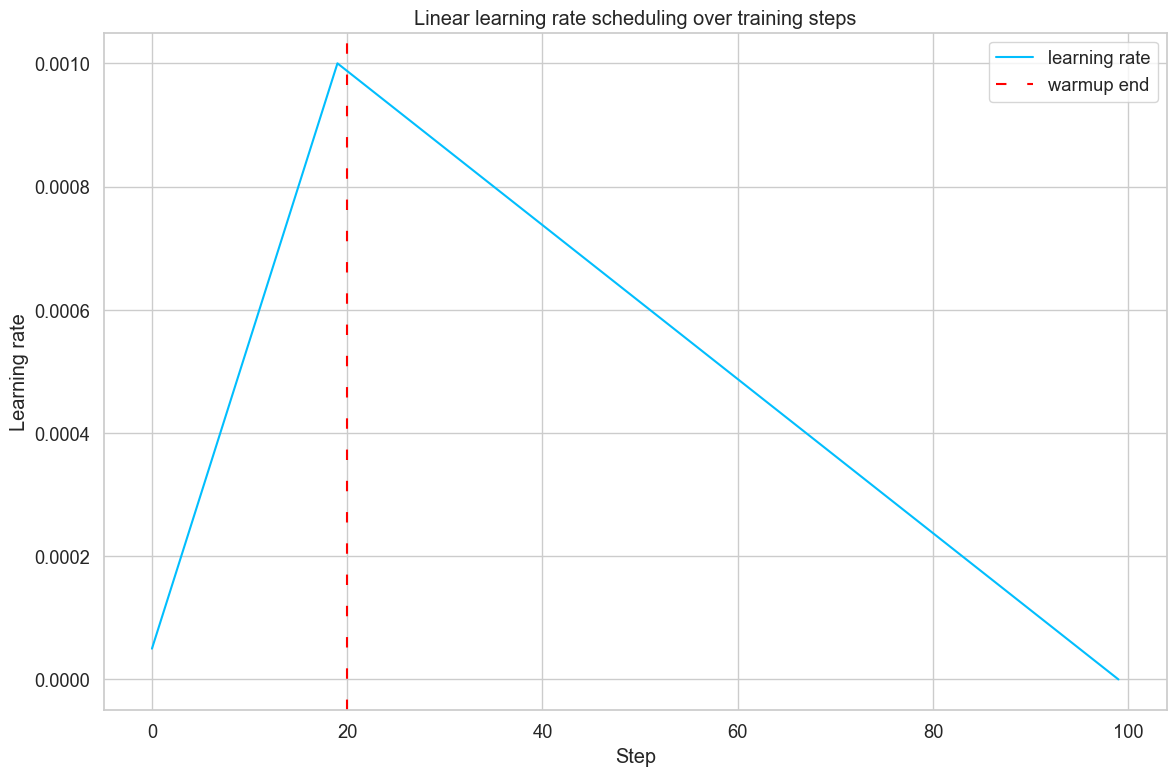

In [64]:
plt.plot(learning_rate_history,label='learning rate')
plt.axvline(x=warmup_steps,color='red',linestyle=(0,(5,10)),label='warmup end')
plt.legend()
plt.title('Linear learning rate scheduling over training steps')
plt.xlabel('Step')
plt.ylabel('Learning rate')
plt.tight_layout();

In [65]:
steps_per_epoch = len(df_train) // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS
warmup_steps = total_training_steps // 5

steps_per_epoch, total_training_steps, warmup_steps

(272, 2720, 544)

In [66]:
model = PersuasionTechniqueDetector(
    n_classes=len(CLASS_NAMES),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

model

PersuasionTechniqueDetector(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [67]:
for param in model.bert.parameters():
    param.requires_grad = False

### Base Model Evaluation

In [68]:
loss = nn.BCELoss()

prediction = torch.FloatTensor(
    [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)

labels = torch.FloatTensor(
    [1., 0., 0., 0., 1., 0.]
)

In [69]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [70]:
loss(torch.sigmoid(prediction),labels)

tensor(0.8725)

In [71]:
_, predictions = model(sample_item['input_ids'].unsqueeze(dim=0),sample_item['attention_mask'].unsqueeze(dim=0))
predictions

tensor([[0.5535, 0.5321, 0.3730, 0.3770, 0.4677, 0.5131, 0.4470, 0.4087, 0.4602,
         0.3766, 0.4414, 0.3911, 0.6186, 0.6189, 0.5411, 0.5516, 0.5841, 0.3551,
         0.5265, 0.5256]], grad_fn=<SigmoidBackward0>)

In [72]:
loss(predictions,sample_item['labels'].unsqueeze(dim=0))

tensor(0.6746, grad_fn=<BinaryCrossEntropyBackward0>)

### ROC Curve

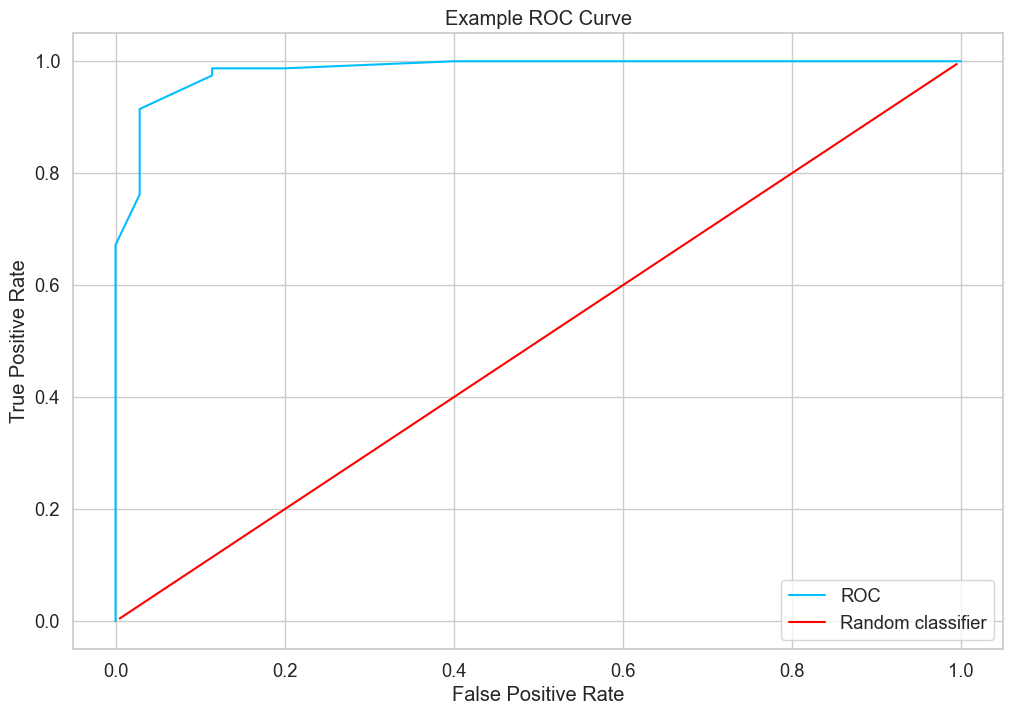

In [73]:
fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]

tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()
ax.plot(fpr,tpr,label='ROC')
ax.plot([0.05,0.95],[0.05,0.95],transform=ax.transAxes,label='Random classifier',color='red')
ax.legend(loc=4)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Example ROC Curve')
plt.show();

### Training the model

In [74]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

In [75]:
logger = TensorBoardLogger('lightning_logs',name='persuasion_techniques')

In [76]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=2)

In [77]:
trainer = pl.Trainer(
    logger=logger,
    callbacks=[early_stopping_callback,checkpoint_callback],
    max_epochs=EPOCHS,
    devices='auto',
    accelerator='auto',
    enable_progress_bar=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [93]:
trainer.fit(model,data_module)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 15.4 K
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.303   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [95]:
import pickle

with open('bert_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')

model saved


In [79]:
import pickle

model = PersuasionTechniqueDetector(
    n_classes=len(CLASS_NAMES),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)
print('Loading model parameters...')
with open('bert_model.pkl','rb') as f:
    model = pickle.load(f)
print('Loaded successfully!')

Loading model parameters...
Loaded successfully!


In [81]:
trained_model = model
trained_model.eval()
trained_model.freeze()

In [110]:
test_meme_text = "WE WILL LEAVE THE COUNTRY IF TRUMP IS ELECTED\\n\\nPLEASE LIKE AND SHARE TO SUPPORT THEIR PLAN!"

encoding = tokenizer.encode_plus(
    test_meme_text,
    add_special_tokens=True,
    max_length=MAX_TOKEN_COUNT,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
)

_, test_prediction = trained_model(encoding['input_ids'],encoding['attention_mask'])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(CLASS_NAMES, test_prediction):
  print(f"{label}: {prediction}")

Presenting Irrelevant Data (Red Herring): 0.01809155009686947
Exaggeration/Minimisation: 0.1819428950548172
Appeal to fear/prejudice: 0.03328298404812813
Reductio ad hitlerum: 0.07580282539129257
Causal Oversimplification: 0.027255546301603317
Name calling/Labeling: 0.06330566853284836
Smears: 0.07059712707996368
Glittering generalities (Virtue): 0.029707372188568115
Whataboutism: 0.05211286619305611
Loaded Language: 0.21723680198192596
Misrepresentation of Someone's Position (Straw Man): 0.028057482093572617
Obfuscation, Intentional vagueness, Confusion: 0.05002221465110779
Appeal to authority: 0.019106950610876083
Black-and-white Fallacy/Dictatorship: 0.04757321998476982
Flag-waving: 0.017268523573875427
Slogans: 0.013271033763885498
Doubt: 0.041354868561029434
Thought-terminating cliché: 0.03531501442193985
Repetition: 0.15337103605270386
Bandwagon: 0.014760727994143963


In [112]:
THRESHOLD = 0.04

test_meme_text = "WE WILL LEAVE THE COUNTRY IF TRUMP IS ELECTED\\n\\nPLEASE LIKE AND SHARE TO SUPPORT THEIR PLAN!"

encoding = tokenizer.encode_plus(
    test_meme_text,
    add_special_tokens=True,
    max_length=MAX_TOKEN_COUNT,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
)

_, test_prediction = trained_model(encoding['input_ids'],encoding['attention_mask'])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(CLASS_NAMES, test_prediction):
    if prediction < THRESHOLD:
        continue
    print(f"{label}: {prediction}")

Exaggeration/Minimisation: 0.1819428950548172
Reductio ad hitlerum: 0.07580282539129257
Name calling/Labeling: 0.06330566853284836
Smears: 0.07059712707996368
Whataboutism: 0.05211286619305611
Loaded Language: 0.21723680198192596
Obfuscation, Intentional vagueness, Confusion: 0.05002221465110779
Black-and-white Fallacy/Dictatorship: 0.04757321998476982
Doubt: 0.041354868561029434
Repetition: 0.15337103605270386


In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = PersuasionDataset(
  df_val,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )

  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [05:59<00:00,  1.39it/s]


In [118]:
accuracy(predictions, labels, threshold=THRESHOLD, task='multilabel', num_labels=len(column_names))

tensor(0.4981)

In [129]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i].unsqueeze(dim=0), labels[:, i].unsqueeze(dim=0), task='multilabel', num_labels=500)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Presenting Irrelevant Data (Red Herring): 0.0


c:\Users\tshar\anaconda3\envs\MLS\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
c:\Users\tshar\anaconda3\envs\MLS\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Exaggeration/Minimisation: 0.0
Appeal to fear/prejudice: 0.0
Reductio ad hitlerum: 0.0
Causal Oversimplification: 0.0
Name calling/Labeling: 0.0
Smears: 0.0
Glittering generalities (Virtue): 0.0
Whataboutism: 0.0
Loaded Language: 0.0
Misrepresentation of Someone's Position (Straw Man): 0.0
Obfuscation, Intentional vagueness, Confusion: 0.0
Appeal to authority: 0.0
Black-and-white Fallacy/Dictatorship: 0.0
Flag-waving: 0.0
Slogans: 0.0
Doubt: 0.0
Thought-terminating cliché: 0.0
Repetition: 0.0
Bandwagon: 0.0


In [124]:
from sklearn.metrics import classification_report

y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

                                                     precision    recall  f1-score   support

           Presenting Irrelevant Data (Red Herring)       0.00      0.00      0.00         4
                          Exaggeration/Minimisation       0.05      1.00      0.10        27
                           Appeal to fear/prejudice       0.07      0.30      0.11        27
                               Reductio ad hitlerum       0.01      1.00      0.02         4
                          Causal Oversimplification       0.00      0.00      0.00        21
                              Name calling/Labeling       0.23      1.00      0.38       116
                                             Smears       0.28      1.00      0.44       142
                   Glittering generalities (Virtue)       0.06      0.08      0.07        36
                                       Whataboutism       0.04      1.00      0.08        21
                                    Loaded Language       0.27      1